# PyData Amsterdam 2019 :: Numba Tutorial Notebook 4 :: Writing CUDA Kernels

## The CUDA Programming Model

Ufuncs (and generalized ufuncs mentioned in the bonus notebook at the end of the tutorial) are the easiest way in Numba to use the GPU, and present an abstraction that requires minimal understanding of the CUDA programming model.  However, not all functions can be written as ufuncs.  Many problems require greater flexibility, in which case you want to write a *CUDA kernel*, the topic of this notebook. 

Fully explaining the CUDA programming model is beyond the scope of this tutorial.  We highly recommend that everyone writing CUDA kernels with Numba take the time to read Chapters 1 and 2 of the CUDA C Programming Guide:

 * Introduction: http://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#introduction
 * Programming Model: http://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#programming-model

The programming model chapter gets a little in to C specifics, but familiarity with CUDA C can help write better CUDA kernels in Python.

For the purposes of this tutorial, the most important thing is to understand this diagram:
![Thread Hierarchy](http://docs.nvidia.com/cuda/cuda-c-programming-guide/graphics/grid-of-thread-blocks.png "Thread Hierarchy (from CUDA C Programming Guide)")

We will be writing a *kernel* that decribes the execution of a single thread in this hierarchy.  The CUDA compiler and driver will execute our kernel across a *thread grid* that is divided into *blocks* of threads.  Threads within the same block can exchange data very easily during the execution of a kernel, whereas threads in different blocks should generally not communicate with each other (with a few exceptions).

Deciding the best size for the CUDA thread grid is a complex problem (and depends on both the algorithm and the specific GPU compute capability), but here are some very rough heuristics that we follow:

  * the size of a block should be a multiple of 32 threads, with typical block sizes between 128 and 512 threads per block.
  * the size of the grid should ensure the full GPU is utilized where possible.  Launching a grid where the number of blocks is 2x-4x the number of "multiprocessors" on the GPU is a good starting place.  Something in the range of 20 - 100 blocks is usually a good starting point.
  * The CUDA kernel launch overhead does depend on the number of blocks, so we find it best not to launch a grid where the number of threads equals the number of input elements when the input size is very big.  We'll show a pattern for dealing with large inputs below.

Each thread distinguishes itself from the other threads using its unique thread (`threadIdx`) and block (`blockIdx`) index values, which can be multidimensional if launched that way.

## A First Example

This all will sound a little overwhelming at first, so let's start with a concrete example.  Let's write our addition function for 1D NumPy arrays.  CUDA kernels are compiled using the `numba.cuda.jit` decorator (not to be confused with the `numba.jit` decorator for the CPU):

In [1]:
from numba import cuda

@cuda.jit
def add_kernel(x, y, out):
    tx = cuda.threadIdx.x # this is the unique thread ID within a 1D block
    ty = cuda.blockIdx.x  # Similarly, this is the unique block ID within the 1D grid

    block_size = cuda.blockDim.x  # number of threads per block
    grid_size = cuda.gridDim.x    # number of blocks in the grid
    
    start = tx + ty * block_size
    stride = block_size * grid_size

    # assuming x and y inputs are same length
    for i in range(start, x.shape[0], stride):
        out[i] = x[i] + y[i]

That's a lot more typing than our ufunc example, and it is much more limited: only works on 1D arrays, doesn't verify input sizes match, etc.  Most of the function is spent figuring out how to turn the block and grid indices and dimensions into unique offsets into the input arrays.  The pattern of computing a starting index and a stride is a common way to ensure that your grid size is independent of the input size.  The striding will maximize bandwidth by ensuring that threads with consecuitive indices are accessing consecutive memory locations as much as possible.  Thread indices beyond the length of the input (`x.shape[0]`, since `x` is a NumPy array) automatically skip over the for loop.

Also note that we did not need to specify a type signature for the CUDA kernel.  Unlike `@vectorize`, Numba can infer the type signature from the inputs automatically, and much more reliably.

Let's call the function now on some data:

In [2]:
import numpy as np

n = 100000
x = np.arange(n).astype(np.float32)
y = 2 * x
out = np.empty_like(x)

threads_per_block = 128
blocks_per_grid = 30

add_kernel[blocks_per_grid, threads_per_block](x, y, out)
print(out[:10])

[ 0.  3.  6.  9. 12. 15. 18. 21. 24. 27.]


The unusual syntax for calling the kernel function is designed to mimic the CUDA Runtime API in C, where the above call would look like:
```
add_kernel<<<blocks_per_grid, threads_per_block>>>(x, y, out)
```
The arguments within the square brackets define the size and shape of the thread grid, and the arguments with parentheses correspond to the kernel function arguments.

Note that, unlike the ufunc, the arguments are passed to the kernel as full NumPy arrays.  The kernel can access any element in the array it wants, regardless of its position in the thread grid.  This is why CUDA kernels are significantly more powerful that ufuncs.  (But with great power, comes a greater amount of typing...)

Numba includes [several helper functions](http://numba.pydata.org/numba-doc/dev/cuda/kernels.html#absolute-positions) to simplify the thread offset calculations above.  You can write the function much more simply as:

In [3]:
@cuda.jit
def add_kernel(x, y, out):
    start = cuda.grid(1)      # 1 = one dimensional thread grid, returns a single value
    stride = cuda.gridsize(1) # ditto

    # assuming x and y inputs are same length
    for i in range(start, x.shape[0], stride):
        out[i] = x[i] + y[i]

As before, using NumPy arrays forces Numba to allocate GPU memory, copy the arguments to the GPU, run the kernel, then copy the argument arrays back to the host.  This not very efficient, so you will often want to allocate device arrays:

In [4]:
x_device = cuda.to_device(x)
y_device = cuda.to_device(y)
out_device = cuda.device_array_like(x)

In [5]:
%timeit add_kernel[blocks_per_grid, threads_per_block](x, y, out)

3.23 ms ± 54.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [6]:
%timeit add_kernel[blocks_per_grid, threads_per_block](x_device, y_device, out_device); out_device.copy_to_host()

416 µs ± 3.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Kernel Synchronization

*One extremely important caveat should be mentioned here*: CUDA kernel execution is designed to be asynchronous with respect to the host program.  This means that the kernel launch (`add_kernel[blocks_per_grid, threads_per_block](x_device, y_device, out_device)`) returns immediately, allowing the CPU to continue executing while the GPU works in the background.  Only host<->device memory copies or an explicit synchronization call will force the CPU to wait until previously queued CUDA kernels are complete.

When you pass host NumPy arrays to a CUDA kernel, Numba has to synchronize on your behalf, but if you pass device arrays, processing will continue.  If you launch multiple kernels in sequence without any synchronization in between, they will be queued up to run sequentially by the driver, which is usually what you want.  If you want to run multiple kernels on the GPU in parallel (sometimes a good idea, but beware of race conditions!), take a look at [CUDA streams](http://numba.pydata.org/numba-doc/dev/cuda-reference/host.html?highlight=synchronize#stream-management).

Here's some sample timings (using `%time`, which only runs the statement once to ensure our measurement isn't affected by the finite depth of the CUDA kernel queue):

In [7]:
# CPU input/output arrays, implied synchronization for memory copies
%time add_kernel[blocks_per_grid, threads_per_block](x, y, out)

CPU times: user 5.13 ms, sys: 4.23 ms, total: 9.36 ms
Wall time: 8.22 ms


In [8]:
# GPU input/output arrays, no synchronization (but force sync before and after)
cuda.synchronize()
%time add_kernel[blocks_per_grid, threads_per_block](x_device, y_device, out_device)
cuda.synchronize()

CPU times: user 4.65 ms, sys: 126 µs, total: 4.78 ms
Wall time: 3.86 ms


In [9]:
# GPU input/output arrays, include explicit synchronization in timing
cuda.synchronize()
%time add_kernel[blocks_per_grid, threads_per_block](x_device, y_device, out_device); cuda.synchronize()

CPU times: user 489 µs, sys: 12.2 ms, total: 12.6 ms
Wall time: 11.7 ms


**Always be sure to synchronize with the GPU when benchmarking CUDA kernels!**

## Atomic Operations and Avoiding Race Conditions

CUDA, like many general purpose parallel execution frameworks, makes it possible to have race condtions in your code.  A race condition in CUDA arises when threads read or write a memory location that might be modified by another independent thread.  Generally speaking, you need to worry about:

 * read-after-write hazards: One thread is reading a memory location at the same time another thread might be writing to it.
 * write-after-write hazards: Two threads are writing to the same memory location, and only one write will be visible when the kernel is complete.
 
A common strategy to avoid both of these hazards is to organize your CUDA kernel algorithm such that each thread has exclusive responsibility for unique subsets of output array elements, and/or to never use the same array for both input and output in a single kernel call.  (Iterative algorithms can use a double-buffering strategy if needed, and switch input and output arrays on each iteration.)

However, there are many cases where different threads need to combine results.  Consider something very simple, like: "every thread increments a global counter."  Implementing this in your kernel requires each thread to:

1. Read the current value of a global counter.
2. Compute `counter + 1`.
3. Write that value back to global memory.

However, there is no guarantee that another thread has not changed the global counter between steps 1 and 3.  To resolve this problem, CUDA provides "atomic operations" which will read, modify and update a memory location in one, indivisible step.  Numba supports several of these functions, [described here](http://numba.pydata.org/numba-doc/dev/cuda/intrinsics.html#supported-atomic-operations).

Let's make our thread counter kernel:

In [10]:
@cuda.jit
def thread_counter_race_condition(global_counter):
    global_counter[0] += 1  # This is bad
    
@cuda.jit
def thread_counter_safe(global_counter):
    cuda.atomic.add(global_counter, 0, 1)  # Safely add 1 to offset 0 in global_counter array

In [11]:
# This gets the wrong answer
global_counter = cuda.to_device(np.array([0], dtype=np.int32))
thread_counter_race_condition[64, 64](global_counter)

print('Should be %d:' % (64*64), global_counter.copy_to_host())

Should be 4096: [1]


In [12]:
# This works correctly
global_counter = cuda.to_device(np.array([0], dtype=np.int32))
thread_counter_safe[64, 64](global_counter)

print('Should be %d:' % (64*64), global_counter.copy_to_host())

Should be 4096: [4096]


## Exercise

For this exercise, create a histogramming kernel.  This will take an array of input data, a range and a number of bins, and count how many of the input data elements land in each bin.  Below is an example CPU implementation of histogramming:

In [13]:
def cpu_histogram(x, xmin, xmax, histogram_out):
    '''Increment bin counts in histogram_out, given histogram range [xmin, xmax).'''
    # Note that we don't have to pass in nbins explicitly, because the size of histogram_out determines it
    nbins = histogram_out.shape[0]
    bin_width = (xmax - xmin) / nbins
    
    # This is a very slow way to do this with NumPy, but looks similar to what you will do on the GPU
    for element in x:
        bin_number = np.int32((element - xmin)/bin_width)
        if bin_number >= 0 and bin_number < histogram_out.shape[0]:
            # only increment if in range
            histogram_out[bin_number] += 1

In [28]:
x = np.random.normal(size=10000, loc=0, scale=1).astype(np.float32)
xmin = np.float32(-4.0)
xmax = np.float32(4.0)
histogram_out = np.zeros(shape=10, dtype=np.int32)

cpu_histogram(x, xmin, xmax, histogram_out)

histogram_out

array([   3,   72,  483, 1521, 2845, 2944, 1587,  458,   80,    5],
      dtype=int32)

In [18]:
%matplotlib inline

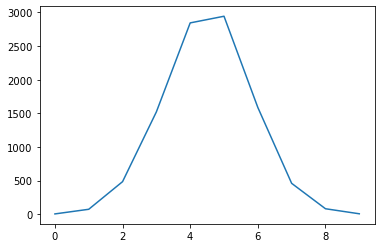

In [29]:
import matplotlib.pyplot as plt
plt.plot(histogram_out)

In [33]:
@cuda.jit
def cuda_histogram(x, xmin, xmax, histogram_out):
    '''Increment bin counts in histogram_out, given histogram range [xmin, xmax).'''
    start = cuda.grid(1)      # 1 = one dimensional thread grid, returns a single value
    stride = cuda.gridsize(1) # ditto
    
    # Note that we don't have to pass in nbins explicitly, because the size of histogram_out determines it
    nbins = histogram_out.shape[0]
    bin_width = (xmax - xmin) / nbins
    
    for element in range(start, x.shape[0], stride):
        bin_number = np.int32((x[element] - xmin)/bin_width)
        if bin_number >= 0 and bin_number < nbins:
            # only increment if in range
            cuda.atomic.add(histogram_out, bin_number, 1)
#             histogram_out[bin_number] += 1

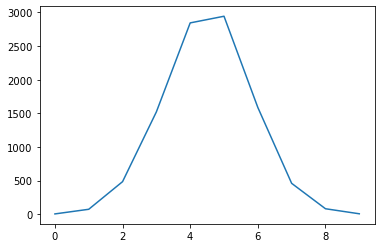

In [34]:
x_device = cuda.to_device(x)
out_device = cuda.device_array_like(np.zeros(shape=10, dtype=np.int32))

threads_per_block = 128
blocks_per_grid = 30

cuda_histogram[blocks_per_grid, threads_per_block](x_device, xmin, xmax, out_device)

histogram_out = out_device.copy_to_host()

histogram_out

plt.plot(histogram_out)